# Gabriel Bertasius & Jaden Ford#

# Predicting Game Success: A Regression Analysis on the Steam Games Dataset #

In [150]:
import numpy as np
import pandas as pd
# show all columns
pd.set_option('display.max_columns', None)

## Downloading and loading data

In [151]:
# load the data into a dataframe for easy handling
import os
from datetime import datetime
import pickle
import gzip
DATASET_DIR = './data/'
DATASET_FILENAME = 'steamgames.parquet'
DATASET_PATH = DATASET_DIR+DATASET_FILENAME
DATASET_COMPRESSION = 'zstd'  # Very fast and compresses as well as gzip
MODELS_DIR = './models/'
MODELS_FILENAME = 'model-'
download_data = 1


def check_file_exists(path: str) -> bool:
    return os.path.exists(path)


def check_data_dir_exists() -> bool:
    return os.path.exists(DATASET_DIR)

def check_models_dir_exists() -> bool:
    return os.path.exists(MODELS_DIR)

def create_data_dir():
    directory_name = DATASET_DIR
    try:
        os.mkdir(directory_name)
        print(f"Directory '{directory_name}' created successfully.")
    except FileExistsError:
        print(f"Directory '{directory_name}' already exists.")
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

def create_models_dir():
    directory_name = MODELS_DIR
    try:
        os.mkdir(directory_name)
        print(f"Directory '{directory_name}' created successfully.")
    except FileExistsError:
        print(f"Directory '{directory_name}' already exists.")
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

def download_steamgames_dataset() -> pd.DataFrame:
    df = pd.read_parquet(
        "hf://datasets/FronkonGames/steam-games-dataset/data/train-00000-of-00001-e2ed184370a06932.parquet")
    return df


def write_dataset_pqt(df: pd.DataFrame, filename: str = DATASET_FILENAME, overwrite: bool = False) -> bool:
    dir = DATASET_DIR
    path = dir+filename
    if (check_data_dir_exists() == False):
        create_data_dir()
    if check_file_exists(path) and overwrite == False:
        print("File exists. Pass 'overwrite' to replace.")
        return False
    else:
        df.to_parquet(path, compression='zstd')
        return True


def read_dataset_pqt(filename: str = DATASET_FILENAME):
    path = DATASET_DIR+filename
    if check_file_exists(path):
        print("Loading dataset from local storage...")
        prq = pd.read_parquet(path)
        print("✅ Local dataset loaded.")
        return prq
    else:
        print("Parquet file not found.")

def datestamp():
    """ Get the current datestamp """
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

def write_model_log(path:str, config: dict, **kwargs):
    with open(path+".txt", "a") as file:
        file.write(f"[{datestamp()}]\n")
        file.write(f"{config}\n")
        if kwargs:
            for x in kwargs:
                file.write(f"{x}\n")

def pickle_model(filename: str, model, params_dict:dict, param_grid:dict = None,overwrite: bool=False, **extra_data):
    dir = MODELS_DIR
    path = dir+filename
    for s in params_dict.values():
        path += f'-{s}'
    if (check_models_dir_exists() == False):
        create_models_dir()
    if check_file_exists(path) and overwrite == False:
        print("File exists. Pass 'overwrite' to replace.")
        return False
    else:
        if param_grid is not None:
            write_model_log(path, param_grid, **extra_data)
        else:
            write_model_log(path, params_dict)
        level = 7   # Good balance between speed and compression
        with gzip.open(path+".pkl.gz", "wb", compresslevel=level) as file:
            pickle.dump(model, file, protocol=5)
        return True

def unpickle_model(filename):
    path = MODELS_DIR+filename
    with gzip.open(path+".pkl.gz", "rb") as file:
        return pickle.load(file)

def download_and_save_dataset(force: bool = False, filename: str = DATASET_FILENAME) -> pd.DataFrame | None:
    dir = DATASET_DIR
    path = dir+filename
    if (check_file_exists(path)):
        print(f"⚠️ Dataset exists locally. Path:{path}")
        if (force == False):
            print("Use force=True to download and overwrite.")
            return None
        else:
            print("Redownloading and Overwriting...")
    else:
        print(f"Downloading and saving dataset to {path} ")
    df = download_steamgames_dataset()
    write_dataset_pqt(df, overwrite=False)
    print("✅ Done.")
    print(f"Saved to: {path}")
    return df


df = download_and_save_dataset(force=False)
if(df is None):
    df = read_dataset_pqt()

⚠️ Dataset exists locally. Path:./data/steamgames.parquet
Use force=True to download and overwrite.
Loading dataset from local storage...
✅ Local dataset loaded.


## Pre-processing data

In [152]:
# Check for any missing values
sum = df.isnull().sum()
sum[sum != 0]

,0
Name,6
About the game,3437
Reviews,73844
Website,44506
Support url,42544
Support email,13319
Metacritic url,79650
Score rank,83516
Notes,70845
Developers,3457


#### Drop irrelevant columns

In [153]:
# remove any columns that won't contribute to a game's success rating
cols_to_remove = ['About the game', 'Supported languages', 'Full audio languages',
                  'Header image', 'Website', 'Support url', 'Support email', 'Metacritic url',
                  'Score rank', 'Screenshots', 'Movies']
df = df.drop(columns=cols_to_remove, axis=1)
df.head()

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,Reviews,Windows,Mac,Linux,Metacritic score,User score,Positive,Negative,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,None,True,False,False,0,0,6,11,30,0,None,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,None,True,True,False,0,0,53,5,12,0,None,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,None,True,False,False,0,0,0,0,0,0,None,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",None
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,None,True,True,True,0,0,3,0,0,0,None,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,None,True,True,False,0,0,50,8,17,0,This Game may contain content not appropriate ...,0,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."


#### Standardizing data and pre-processing

In [154]:
# function that calculates the number of years since a game's release date
from datetime import datetime
def years_since_release(date_string):
  if len(date_string) == 11 or len(date_string) == 12:
        date = datetime.strptime(date_string, "%b %d, %Y")
  else: # length must be 8 or 9
      date = datetime.strptime(date_string, "%b %Y")

  current_date = datetime.now()
  years = (current_date - date).days / 365
  return years

# function to return the avg number of estimated owners
def est_owners(num_owners):
  numbers = num_owners.split('-')
  return (int(numbers[0]) + int(numbers[1])) / 2

# function to normalize a numerical column between 0-1 based on min and and max values
def min_max_normalize(column):
  column = np.array(column)
  norm_col = ( column - np.min(column) ) / ( np.max(column) - np.min(column) )
  return norm_col

In [155]:
# convert release date to years since release
df['Release date'] = df['Release date'].apply(years_since_release)

# return middle value for each given range of estimated owners
df['Estimated owners'] = df['Estimated owners'].apply(est_owners)

# convert windows, mac, and linux columns from boolean to integer
df['Windows'] = df['Windows'].astype(int)
df['Mac'] = df['Mac'].astype(int)
df['Linux'] = df['Linux'].astype(int)

In [156]:
# Filter out any games that are free, have no peak ccu, and no estimated owners
# This allows us to judge success based on games that competed in certain markets, and have had actual people play them
no_peak_ccu_cols = df[df['Peak CCU'] == 0].index
df = df.drop(no_peak_ccu_cols, axis=0)

no_est_owners_cols = df[df['Estimated owners'] == 0].index
df = df.drop(no_est_owners_cols, axis=0)

no_price_cols = df[df['Price'] == 0].index
df = df.drop(no_price_cols, axis=0)

Data for later use in sentiment analysis and model performance calculations.

In [157]:
# keep a copy of pre_normalized values
df_orig = df.copy(deep=True)

# store reviews for sentiment analysis
df_reviews = df['Reviews'].copy(deep=True)

In [158]:
# normalize any large value ranges
cols_to_normalize = ['Release date', 'Estimated owners', 'Peak CCU', 'Required age', 'Price', 'DLC count',
                     'Metacritic score', 'User score', 'Positive', 'Negative', 'Achievements',
                     'Recommendations', 'Average playtime forever', 'Average playtime two weeks',
                     'Median playtime forever', 'Median playtime two weeks']
for col in cols_to_normalize:
  df[col] = min_max_normalize(df[col])

In [159]:
# If we want to remove rows that have no reviews, we would have 4269 examples
#df = df.dropna(axis=0, subset='Reviews')
#print(df.shape[0])
#df.isnull().sum()

In [160]:
print(df.shape)
df.head()

(20194, 28)


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,Reviews,Windows,Mac,Linux,Metacritic score,User score,Positive,Negative,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags
6,1659180,TD Worlds,0.071606,0.000000,0.000002,0.0,0.039460,0.000423,None,1,0,0,0.000000,0.0,0.000022,0.000051,0.006313,0.000000,None,0.00000,0.0,0.000000,0.0,MAKSIM VOLKAU,MAKSIM VOLKAU,"Single-player,Steam Achievements,Steam Cloud","Indie,Strategy","Tower Defense,Rogue-lite,RTS,Replay Value,Perm..."
7,1968760,Legend of Rome - The Wrath of Mars,0.059585,0.000000,0.000001,0.0,0.035751,0.000000,None,1,0,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,None,0.00000,0.0,0.000000,0.0,magnussoft,magnussoft,"Single-player,Steam Cloud",Casual,None
8,1178150,MazM: Jekyll and Hyde,0.138653,0.000000,0.000000,0.0,0.054295,0.000000,None,1,0,0,0.000000,0.0,0.000079,0.000043,0.002546,0.000000,None,0.00000,0.0,0.000000,0.0,Growing Seeds,"CFK Co., Ltd.","Single-player,Steam Achievements,Full controll...","Adventure,RPG,Simulation,Strategy","Adventure,Simulation,RPG,Strategy,Singleplayer..."
10,1026420,WARSAW,0.157617,0.000333,0.000005,0.0,0.087672,0.000000,“New WW2 Strategy Game Offers A Harrowing Look...,1,0,0,0.639175,0.0,0.000610,0.001530,0.003462,0.000475,None,0.00046,0.0,0.000446,0.0,Pixelated Milk,"Pixelated Milk,gaming company","Single-player,Steam Achievements,Steam Trading...","Indie,RPG","Tactical RPG,Turn-Based Strategy,Wargame,Histo..."
14,1454010,Diary of Lucie,0.114093,0.000000,0.000002,0.0,0.046877,0.000000,None,1,0,0,0.000000,0.0,0.000104,0.000036,0.000000,0.000000,None,0.00000,0.0,0.000000,0.0,Parange Project,Parange Project,"Single-player,Partial Controller Support,Steam...","Action,Adventure,Indie,RPG,Strategy,Early Access","Action Roguelike,Action,Rogue-lite,RPGMaker,My..."


### Counting unique words in Categories, Genres, Tags

'Dumb counting' as in the tags 'turn-based' and 'turn-based combat' or 'turn-based strategy' are different words. These should be ok for word2vec as they're similar.

In [161]:
df.columns
df['Tags']

def count_unique_words(df, label:str):
    lists:pd.Series= df[label].str.casefold().str.split(',')
    words = set()
    [words.update(x) for x in lists if x is not None]
    print(f"Number of unique {label}: {len(words)}")
    return len(words)

count_unique_words(df, 'Categories') # 39
count_unique_words(df, 'Genres') # 27
count_unique_words(df, 'Tags') # 444
pass;

Number of unique Categories: 39
Number of unique Genres: 27
Number of unique Tags: 444


#### One hot encoding Catergories and Genres

In [162]:
encoded_categories = df['Categories'].str.get_dummies(sep=',')
encoded_genres = df['Genres'].str.get_dummies(sep=',')

df = pd.concat([df, encoded_categories, encoded_genres], axis=1)
df = df.drop(columns=['Categories', 'Genres'], axis=1)
print(df.shape)

(20194, 92)


### Word2Vec embedding for Tags feature

Currently the embedding for the tags is an average of the tags for a given game. This results in d-dimensional feature embedding where d is the numer of dimensions specified in word2vec training.

todo: process hyphenated and multi-word tags. Treat as one phrase by subbing dashes and spaces with an underline

todo: tuning: what do the parameters do? what can be tweaked? what is desired?

todo: CBOW vs CSkipGram

In [163]:
label = 'Tags'
lists:pd.Series= df[label].str.casefold().str.split(',')
# lists.fillna('none')
lists = lists.apply(lambda x: ['none'] if x is None else x)
sentences = [x for x in lists]

In [164]:
print(sentences[9])

['flight', 'simulation', 'vr', 'racing', 'physics', 'open world', 'realistic', 'education', 'exploration', 'jet', '3d vision', 'relaxing', '3d', 'level editor', 'america', 'singleplayer', 'trackir', 'early access', 'indie', 'multiplayer']


#### Training word2vec model

In [165]:
import gensim
from sklearn import svm
from sklearn.model_selection import train_test_split
class s_word2vec:
# model_name = "100features_1minwords_10context"
    def __init__(self):
        self.model = None
        self.num_features = 100# Word vector dimensionality
        self.min_word_count = 1  # Minimum word count
        self.context = 10 # Context window size
        self.model_name = f'{self.num_features}-feat_{self.min_word_count}-minwords_{self.context}-context'

        self.num_workers = 8  # Number of threads to run in parallel
        self.downsampling = 1e-3  # Downsample setting for frequent words

    def _init_sims(self, model):
        # If you don't plan to train the model any further, calling
        # init_sims will make the model much more memory-efficient.
        print("get_mean_vector is deprecated. Use get_vector(key, norm=True) instead")
        self.model.init_sims(replace=True)

    def load_or_train_model(self):
        if check_file_exists(self.model_name):
            print("Loading saved model: ", self.model_name)
            self.model = gensim.models.Word2Vec.load(self.model_name)
            self._init_sims(self.model)

        else:
            # Code from:
            # https://www.kaggle.com/competitions/word2vec-nlp-tutorial/overview

            print("Training model...")
            self.model = gensim.models.Word2Vec(
                sentences,
                workers=self.num_workers,
                vector_size=self.num_features,
                min_count=self.min_word_count,
                window=self.context,
                sample=self.downsampling,
            )
            # It can be helpful to create a meaningful model name and
            # save the model for later use. You can load it later using Word2Vec.load()
            self.model.save(self.model_name)


tags_w2v_model = s_word2vec()
tags_w2v_model.load_or_train_model()
model:gensim.models.Word2Vec = tags_w2v_model.model


<ipython-input-165-60086ad08254>:20: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.model.init_sims(replace=True)


Loading saved model:  100-feat_1-minwords_10-context
get_mean_vector is deprecated. Use get_vector(key, norm=True) instead


Vector of the tag 'singleplayer'

In [166]:
sent = model.wv.get_mean_vector(sentences[9][1:])
model.wv.similar_by_vector(sent, topn=len(sentences[9]))

[('offroad', 0.8526350259780884),
 ('trackir', 0.8515264391899109),
 ('driving', 0.8448815941810608),
 ('6dof', 0.826041579246521),
 ('realistic', 0.8205005526542664),
 ('atv', 0.8185087442398071),
 ('physics', 0.8154350519180298),
 ('3d vision', 0.8137850761413574),
 ('automobile sim', 0.7951775789260864),
 ('underwater', 0.7937729358673096),
 ('dinosaurs', 0.7891889810562134),
 ('transportation', 0.7817903757095337),
 ('motocross', 0.7718392014503479),
 ('snowboarding', 0.7695859670639038),
 ('bikes', 0.7673637270927429),
 ('snow', 0.7593293190002441),
 ('vr only', 0.7451286315917969),
 ('cycling', 0.730832040309906),
 ('asymmetric vr', 0.727423906326294),
 ('immersive sim', 0.7228519320487976)]

In [167]:
print(len(model.wv.index_to_key))
print(model.wv.index_to_key[3])
model.wv['action'][:10]

445
action


array([-1.3042289e-01,  5.8996836e-03,  1.1795081e-01,  1.2897473e-04,
        4.7862355e-02, -5.2216887e-02, -9.1536753e-02,  9.9952266e-02,
        1.4136402e-01,  1.0996699e-02], dtype=float32)

#### Visualizing word2vec tag vectors

Using TSNE we can visualize the clustering of similar word vectors in word2vec model.

In [170]:
#!pip install -q adjustText

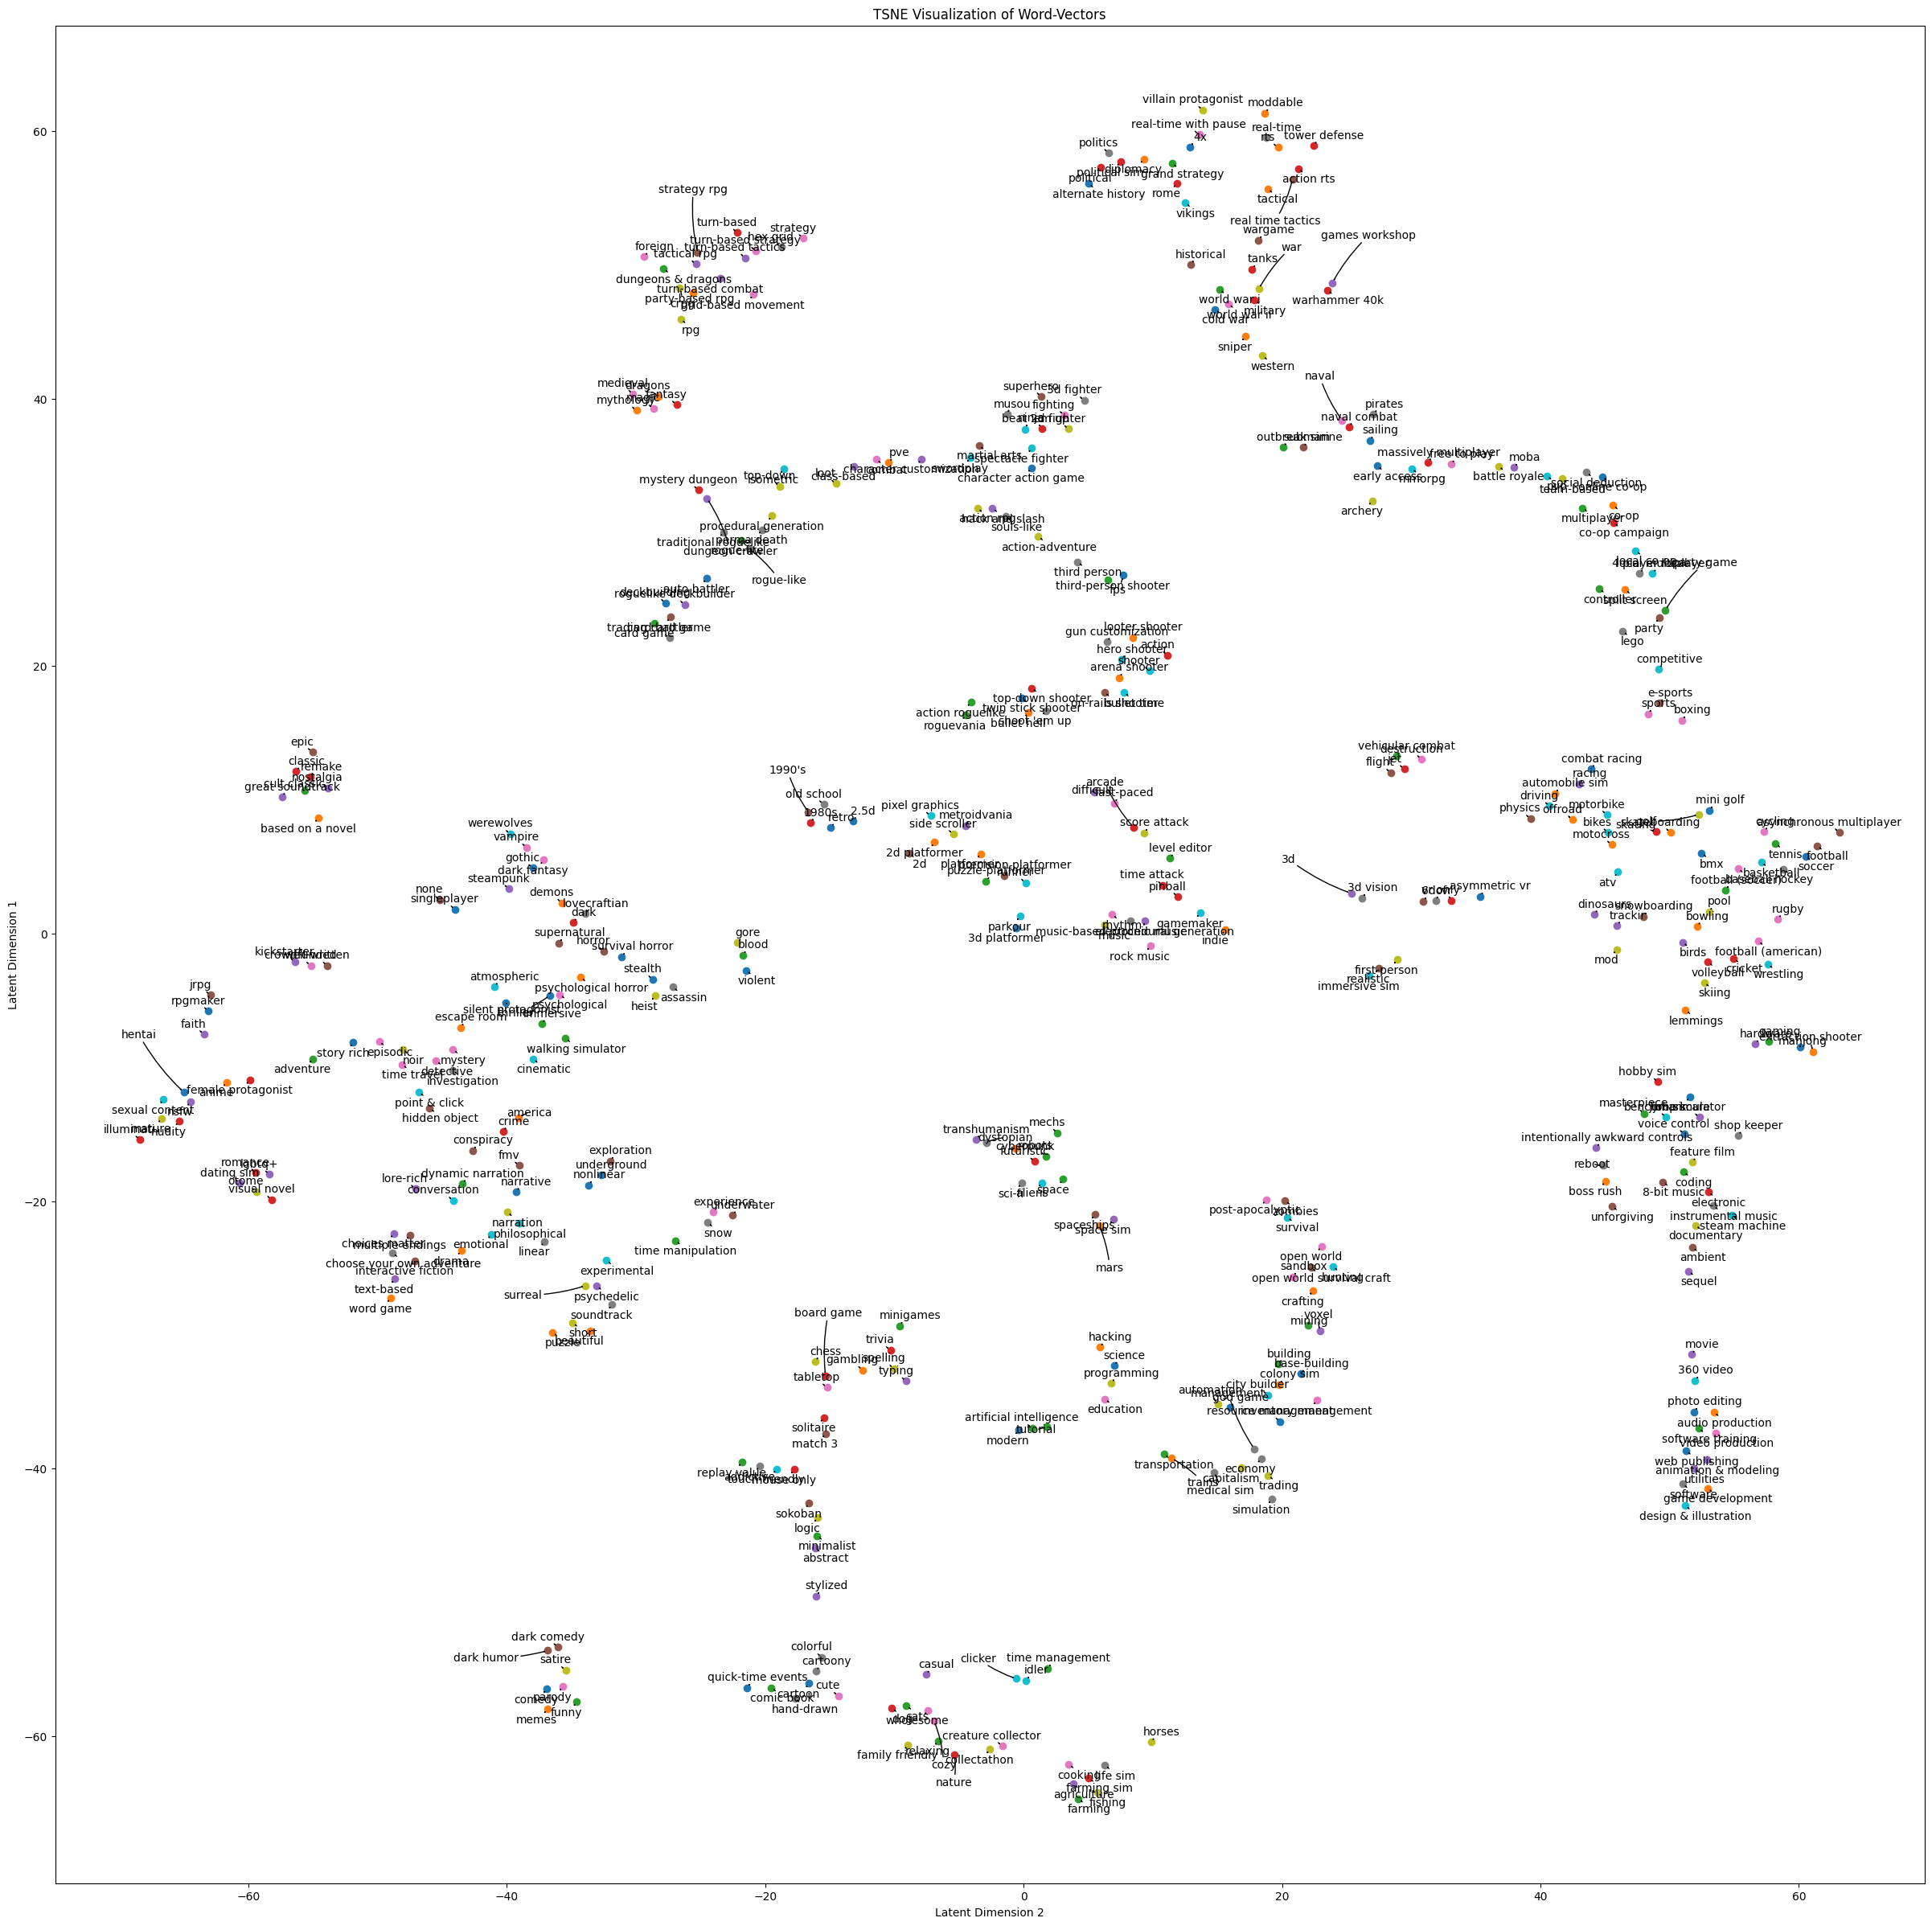

In [169]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# conda install adjustText::conda-forge
from adjustText import adjust_text
from sklearn.decomposition import PCA

""" Code for graphing from:
    https://github.com/arsena-k/Word2Vec-bias-extraction/blob/master/Part_A_W2V_training_performance_exploring.ipynb
"""
def tsne_plot(words, vectors, iterations, seed, title):
    "Creates and TSNE model and plots it"
    # you may need to tune these, epsecially the perplexity.
    tsne_model = TSNE(
        perplexity=7,
        n_components=2,
        init="pca",
        max_iter=iterations,
        random_state=seed,
        n_jobs=-1,
    )
    new_values = tsne_model.fit_transform(np.asarray(vectors))
    # pca = PCA(2, svd_solver='full', random_state=42)
    # new_values = pca.fit_transform(np.asarray(vectors))

    x,y, texts = [],[],[]
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(30, 30))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        texts.append( plt.text(
                s=words[i],
                #  xy=(x[i], y[i]),
                x=x[i], y=y[i],
                #  xytext=(x[i] + 0.1, y[i] - 0.2),
                #   xytext=(5, 2),
                #  textcoords='offset points',
                ha="center", va="center",))
    adjust_text(
        texts,
        expand=(6,5),
        explode_radius=(15),
        avoid_self=False,
        max_move=(13,13),
        force_text=(4,5),
        force_explode=(5,5),
        # force_static=(10,15),
        # pull_threshold=20,
        # force_pull=(0.1,0.1),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.08"),
    )
    plt.ylabel("Latent Dimension 1")
    plt.xlabel("Latent Dimension 2")
    plt.title(title)
    plt.show()


my_word_list, my_word_vectors, label = [], [], []

for i in model.wv.index_to_key:
    try:
        if my_word_list not in my_word_list:
            my_word_vectors.append(model.wv[i])
            my_word_list.append(i)
    except (
        KeyError
    ):  # if one of the words_to_explore is not in the model vocab, just skip it
        continue

tsne_plot(my_word_list, my_word_vectors, iterations=2000, seed=23, title="TSNE Visualization of Word-Vectors")

#### Averging word2vec vectors
The tag vectors corresponding to each game from the word2vec model are averaged to prepare a 100 dimensional embedding.


In [171]:
model.wv.most_similar('action', topn=10)
model.wv.similar_by_word('action', topn=10) # same result

[('shooter', 0.6103335618972778),
 ('looter shooter', 0.5860500335693359),
 ('hero shooter', 0.5432348847389221),
 ('arena shooter', 0.5394299030303955),
 ('third-person shooter', 0.5243836045265198),
 ('hack and slash', 0.49123647809028625),
 ('bullet time', 0.48817259073257446),
 ('blood', 0.4871032238006592),
 ('ninja', 0.48493993282318115),
 ('souls-like', 0.48006799817085266)]

In [172]:
words = model.wv.index_to_key
words[0:10]
model.wv.most_similar('none') # this needs fixin

[('singleplayer', 0.2402019202709198),
 ('simulation', 0.12187318503856659),
 ('rpg', 0.10403453558683395),
 ('adventure', 0.09888770431280136),
 ('dungeon crawler', 0.0877128466963768),
 ('replay value', 0.07916799932718277),
 ('realistic', 0.06799497455358505),
 ('relaxing', 0.06637871265411377),
 ('crpg', 0.06585758924484253),
 ('sailing', 0.062111981213092804)]

In [173]:
"""
    pre-normalizing will discard sentence length information
    this should ignore differences in numbe of tags specified for each game
    Pre-normalize doesnt matter if init_sims(replace=True) since it will
    precompute normalized vectors.
    Not clear what the point of post_normalize is. May be/not good for training
    the regression model down the line.
"""

tags_vectors = [
    model.wv.get_mean_vector(game, pre_normalize=False, post_normalize=False)
    for game in sentences
]

In [174]:
# print('Number of games', len(tags_vectors))
# model.wv.similar_by_vector(tags_vectors[0],topn=20)
# np.mean(tags_vectors[0])
# np.linalg.norm(tags_vectors[0])

In [175]:
df['Tags'][6]

'Tower Defense,Rogue-lite,RTS,Replay Value,Perma Death,2D,Isometric,Difficult,Rogue-like,Dynamic Narration,Stylized,Real Time Tactics,Strategy,Minimalist,Abstract,Tactical,Atmospheric,Singleplayer,Sci-fi,Mystery'

In [176]:
w2vdf = pd.DataFrame(tags_vectors)
assert w2vdf.shape[1] == tags_w2v_model.num_features
w2vdf.columns = [f'w2v_embed_{i}' for i in range(tags_w2v_model.num_features)]
w2vdf.head()

,w2v_embed_0,w2v_embed_1,w2v_embed_2,w2v_embed_3,w2v_embed_4,w2v_embed_5,w2v_embed_6,w2v_embed_7,w2v_embed_8,w2v_embed_9,w2v_embed_10,w2v_embed_11,w2v_embed_12,w2v_embed_13,w2v_embed_14,w2v_embed_15,w2v_embed_16,w2v_embed_17,w2v_embed_18,w2v_embed_19,w2v_embed_20,w2v_embed_21,w2v_embed_22,w2v_embed_23,w2v_embed_24,w2v_embed_25,w2v_embed_26,w2v_embed_27,w2v_embed_28,w2v_embed_29,w2v_embed_30,w2v_embed_31,w2v_embed_32,w2v_embed_33,w2v_embed_34,w2v_embed_35,w2v_embed_36,w2v_embed_37,w2v_embed_38,w2v_embed_39,w2v_embed_40,w2v_embed_41,w2v_embed_42,w2v_embed_43,w2v_embed_44,w2v_embed_45,w2v_embed_46,w2v_embed_47,w2v_embed_48,w2v_embed_49,w2v_embed_50,w2v_embed_51,w2v_embed_52,w2v_embed_53,w2v_embed_54,w2v_embed_55,w2v_embed_56,w2v_embed_57,w2v_embed_58,w2v_embed_59,w2v_embed_60,w2v_embed_61,w2v_embed_62,w2v_embed_63,w2v_embed_64,w2v_embed_65,w2v_embed_66,w2v_embed_67,w2v_embed_68,w2v_embed_69,w2v_embed_70,w2v_embed_71,w2v_embed_72,w2v_embed_73,w2v_embed_74,w2v_embed_75,w2v_embed_76,w2v_embed_77,w2v_embed_78,w2v_embed_79,w2v_embed_80,w2v_embed_81,w2v_embed_82,w2v_embed_83,w2v_embed_84,w2v_embed_85,w2v_embed_86,w2v_embed_87,w2v_embed_88,w2v_embed_89,w2v_embed_90,w2v_embed_91,w2v_embed_92,w2v_embed_93,w2v_embed_94,w2v_embed_95,w2v_embed_96,w2v_embed_97,w2v_embed_98,w2v_embed_99
0,-0.027324,-0.040016,-0.011166,0.025026,-0.014047,-0.095823,-0.070264,0.019024,0.043354,0.002442,-0.083185,0.019347,-0.081690,0.042101,-0.039346,-0.021919,-0.030411,-0.053246,-0.108249,0.015595,-0.019435,-0.010668,0.003212,0.043837,0.070786,0.009341,0.003221,-0.071108,0.045556,0.028446,0.042337,0.047542,0.016128,0.051055,-0.037740,0.028913,0.094338,-0.036806,0.022316,-0.051422,-0.035301,-0.003934,-0.059894,-0.084784,0.034795,-0.082249,-0.001824,-0.026033,0.145499,-0.019461,-0.019965,-0.013832,0.130459,0.050822,0.056255,-0.008374,-0.016285,-0.059756,-0.042870,-0.017219,0.026232,-0.029324,0.002395,-0.083357,0.019883,0.059595,-0.035919,0.019562,-0.014869,-0.003426,-0.072827,0.050732,-0.033832,-0.039081,0.013756,0.119822,0.030885,0.013958,-0.038303,-0.012239,0.063202,-0.037228,-0.048032,0.089205,-0.014052,0.002895,-0.044781,-0.027088,-0.025481,0.030598,0.046463,0.127499,0.003064,0.029965,0.110978,0.008738,0.015769,0.034290,0.059873,-0.025294
1,0.141421,-0.114861,0.103163,-0.003875,-0.160798,-0.043488,-0.028207,-0.079774,-0.014132,-0.093262,0.105763,0.165632,-0.028266,0.060118,-0.013317,-0.012456,-0.124812,0.025938,0.069481,0.123023,0.116414,0.062964,0.082994,-0.132317,-0.024684,-0.102951,0.121082,0.139341,-0.076092,0.020539,0.090965,0.032215,0.013992,-0.119998,0.175055,-0.129248,-0.107422,-0.100876,-0.113016,-0.062153,-0.167358,0.020975,-0.066767,-0.045422,0.102992,0.063211,0.032419,-0.024463,0.175853,0.005102,0.089292,0.160903,-0.173879,-0.162997,0.176660,0.048724,-0.033570,0.084105,-0.076829,-0.113900,-0.147010,0.128365,-0.043607,-0.134294,-0.105225,0.109945,-0.044147,-0.109416,-0.028806,-0.026234,-0.057947,-0.037196,0.073096,0.025754,-0.062140,0.047933,0.093093,-0.163628,-0.134564,0.112097,-0.159129,0.009404,-0.160121,0.149012,-0.076440,-0.117868,-0.024636,-0.019827,0.134114,0.162181,-0.006245,0.047955,0.084338,0.002542,-0.102904,-0.010583,0.038864,0.147799,-0.063956,-0.175284
2,-0.025940,0.011332,0.019381,0.052638,-0.018899,-0.020921,0.014625,0.040421,-0.065950,0.047033,-0.017785,-0.007086,0.012712,0.014332,-0.044124,0.002619,0.047456,-0.040639,-0.052589,-0.029008,0.074299,0.096774,0.017907,-0.014278,0.035841,0.024532,0.003274,-0.030873,-0.041606,0.066015,0.028167,-0.038584,0.057116,-0.041112,-0.054046,0.002552,-0.011673,-0.028559,-0.075198,-0.050762,-0.032070,0.034812,-0.001591,-0.080811,-0.066610,-0.056207,0.007261,-0.051086,-0.020586,0.003280,-0.033267,0.083146,0.008776,-0.003330,0.014610,-0.054105,-0.099400,0.000555,0.000829,0.050672,-0.011338,-0.026310,-0.035132,-0.022409,-0.041469,0.080544,-0.011942,-0.001891,-0.029971,-0.014214,-0.029963,-0.020966,-0.016949,-0.010050,0.006079,0.051365,-0.024327,0.057543,0.003343,0.002299,-0.036193,-0.041904,-0.038016,0.

#### Dropping Tags columns and merging embeds

In [177]:
""" Trick to prevent this from executing twice """
try:
    check_if_w2vdf_already_concat
except NameError:
    df.drop(columns=['Tags'])
    df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, w2vdf], axis=1)
    check_if_w2vdf_already_concat = 1

# del check_if_w2vdf_already_concat

### HDBSCAN clustering


In [181]:
df.head()

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,Reviews,Windows,Mac,Linux,Metacritic score,User score,Positive,Negative,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Tags,Captions available,Co-op,Commentary available,Cross-Platform Multiplayer,Full controller support,HDR available,In-App Purchases,Includes Source SDK,Includes level editor,LAN Co-op,LAN PvP,MMO,Multi-player,Online Co-op,Online PvP,Partial Controller Support,PvP,Remote Play Together,Remote Play on Phone,Remote Play on TV,Remote Play on Tablet,Shared/Split Screen,Shared/Split Screen Co-op,Shared/Split Screen PvP,Single-player,Stats,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,Tracked Motion Controller Support,VR Only,VR Support,VR Supported,Valve Anti-Cheat enabled,Accounting,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Early Access,Education,Free to Play,Game Development,Gore,Indie,Massively Multiplayer,Nudity,Photo Editing,RPG,Racing,Sexual Content,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Violent,Web Publishing,w2v_embed_0,w2v_embed_1,w2v_embed_2,w2v_embed_3,w2v_embed_4,w2v_embed_5,w2v_embed_6,w2v_embed_7,w2v_embed_8,w2v_embed_9,w2v_embed_10,w2v_embed_11,w2v_embed_12,w2v_embed_13,w2v_embed_14,w2v_embed_15,w2v_embed_16,w2v_embed_17,w2v_embed_18,w2v_embed_19,w2v_embed_20,w2v_embed_21,w2v_embed_22,w2v_embed_23,w2v_embed_24,w2v_embed_25,w2v_embed_26,w2v_embed_27,w2v_embed_28,w2v_embed_29,w2v_embed_30,w2v_embed_31,w2v_embed_32,w2v_embed_33,w2v_embed_34,w2v_embed_35,w2v_embed_36,w2v_embed_37,w2v_embed_38,w2v_embed_39,w2v_embed_40,w2v_embed_41,w2v_embed_42,w2v_embed_43,w2v_embed_44,w2v_embed_45,w2v_embed_46,w2v_embed_47,w2v_embed_48,w2v_embed_49,w2v_embed_50,w2v_embed_51,w2v_embed_52,w2v_embed_53,w2v_embed_54,w2v_embed_55,w2v_embed_56,w2v_embed_57,w2v_embed_58,w2v_embed_59,w2v_embed_60,w2v_embed_61,w2v_embed_62,w2v_embed_63,w2v_embed_64,w2v_embed_65,w2v_embed_66,w2v_embed_67,w2v_embed_68,w2v_embed_69,w2v_embed_70,w2v_embed_71,w2v_embed_72,w2v_embed_73,w2v_embed_74,w2v_embed_75,w2v_embed_76,w2v_embed_77,w2v_embed_78,w2v_embed_79,w2v_embed_80,w2v_embed_81,w2v_embed_82,w2v_embed_83,w2v_embed_84,w2v_embed_85,w2v_embed_86,w2v_embed_87,w2v_embed_88,w2v_embed_89,w2v_embed_90,w2v_embed_91,w2v_embed_92,w2v_embed_93,w2v_embed_94,w2v_embed_95,w2v_embed_96,w2v_embed_97,w2v_embed_98,w2v_embed_99
0,1659180,TD Worlds,0.071606,0.000000,0.000002,0.0,0.039460,0.000423,None,1,0,0,0.000000,0.0,0.000022,0.000051,0.006313,0.000000,None,0.00000,0.0,0.000000,0.0,MAKSIM VOLKAU,MAKSIM VOLKAU,"Tower Defense,Rogue-lite,RTS,Replay Value,Perm...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-0.027324,-0.040016,-0.011166,0.025026,-0.014047,-0.095823,-0.070264,0.019024,0.043354,0.002442,-0.083185,0.019347,-0.081690,0.042101,-0.039346,-0.021919,-0.030411,-0.053246,-0.108249,0.015595,-0.019435,-0.010668,0.003212,0.043837,0.070786,0.009341,0.003221,-0.071108,0.045556,0.028446,0.042337,0.047542,0.016128,0.051055,-0.037740,0.028913,0.094338,-0.036806,0.022316,-0.051422,-0.035301,-0.003934,-0.059894,-0.084784,0.034795,-0.082249,-0.001824,-0.026033,0.145499,-0.019461,-0.019965,-0.013832,0.130459,0.050822,0.056255,-0.008374,-0.016285,-0.059756,-0.042870,-0.017219,0.026232,-0.029324,0.002395,-0.083357,0.019883,0.059595,-0.035919,0.019562,-0.014869,-0.003426,-0.072827,0.050732,-0.033832,-0.039081,0.013756,0.119822,0.030885,0.013958,-0.038303,-0.012239,0.063202,-0.037228,-0.048032,0.089205,-0.014052,0.002895,-0.044781,-0.027088,-0.025481,0.030598,0.046463,0.127499,0.003064,0.029965,0.110978,0.008738,0.015769,0.034290,0.059873,-0.025294
1,1968760,Legend of Rome - The Wrath of Mars,0.059585,0.000000,0.000

In [182]:
# X_train, X_test = train_test_split(tags_vectors, test_size=0.2, train_size=0.8, random_state=42, shuffle=True)

## Processing Reviews Using Sentiment Analysis

In [183]:
df_reviews.notna().sum()

4269

There are 4269 reveiws which we can analyze for sentiment. Using the Twitter Roberta model we get three scores (negative, neutral, positive) which are computed into a compound score using a simple weighting of [-1, 0, 1], respectively, and a dot product of the scores. These scores are then gathered and averaged into a single score for each game.

Please unzip the sentiment model from the google drive folder into the models directory.

When unzipped, the models directory should contain the folder `twitter-roberta-base-sentiment-latest` with 5 files inside.

In [184]:
#!pip install -q transformers
#!pip install -q scipy
#!pip install torch -q torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [272]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import torch


def calculate_sentiment():
    roberta_path = 'models/twitter-roberta-base-sentiment-latest'
    MODEL = roberta_path  # f"cardiffnlp/twitter-roberta-base-sentiment-latest"
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    config = AutoConfig.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL);


    def preprocess(text: str):
        if (text.find("“") != -1):
            p = text.split("“")
            p = [x.split("”")[0].strip() for x in p]
            p = p[1:]
        else:
            # if it's just a single review or follows a different format
            # then just treat the whole string as a review
            p = [text]
        return p

    def calculate_compound_score(scores):
        sentiment_probabilities = np.asarray(scores)
        weights = np.array([-1, 0, 1], dtype=np.float32)
        return np.dot(sentiment_probabilities, weights)


    s = df_reviews[df_reviews.notna()]
    s = s.apply(preprocess)
    # Tweak batch to your system.
    # Mem Usage: 10-50 is safe. ~25 may be fastest. Needs around 8gb ram.
    #=========
    batch_size = 25
    #=========
    scores = []
    for i in range(0, s.size, batch_size): # compute in batches
        p = s[i:i + batch_size]
        pretokenized = [review for row in p.tolist() for review in row] # create a list of reviews
        # pretokenized = "New WW2 Strategy Game Offers A Harrowing Look At Poland's Ill-Fated 1944 Uprising"
        # compute the tokens
        encoded_input = tokenizer(
            pretokenized, truncation=True, padding=True, max_length=512, return_tensors='pt')
        with torch.no_grad():
            output = model(**encoded_input)
        # gather scores in each batch
        scores.extend([calculate_compound_score(softmax(logits.numpy()))
                      for logits in output.logits])


    row_lengths = [len(reviews) for reviews in s.tolist()]
    row_lengths
    game_sentiments = np.split(scores, np.cumsum(row_lengths)) # review scores grouped by game

    if(game_sentiments[-1].shape == (0,)):
        game_sentiments = game_sentiments[:-1]

    game_sentiments = [np.mean(x) for x in game_sentiments] # average the score for each game

    df_review_scores = pd.Series(game_sentiments, index=s.index) # re-index

    # Copy df_reviews to avoid overwriting
    df_reviews_with_scores = df_reviews.copy()

    # Assign scores to the corresponding indices in the new series
    df_reviews_with_scores.loc[df_review_scores.index] = df_review_scores

    print(df_reviews_with_scores)
    return df_reviews_with_scores

try:
    df_reviews_with_scores = unpickle_model('df_reviews_with_scores-values')
except:
    print('No stored values found. Running fresh sentiment analysis.')
    df_reviews_with_scores = calculate_sentiment()

In [273]:
# pickle_model('df_reviews_with_scores', df_reviews_with_scores, {'no':'values'})
print(df_reviews_with_scores.shape)
df_reviews_with_scores

(20194,)


,Reviews
6,None
7,None
8,None
10,0.302433
14,None
...,...
83530,None
83535,None
83537,None
83541,None


In [274]:
# Leave any games with no reviews with a neutral sentiment rating (0)
df_reviews_with_scores = df_reviews_with_scores.fillna(0)
df_reviews_with_scores

<ipython-input-274-afefd0e0176e>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reviews_with_scores = df_reviews_with_scores.fillna(0)


,Reviews
6,0.000000
7,0.000000
8,0.000000
10,0.302433
14,0.000000
...,...
83530,0.000000
83535,0.000000
83537,0.000000
83541,0.000000


In [262]:
print(type(df_reviews_with_scores[6]))

<class 'NoneType'>


## Train/test data extraction + Regression model selection

The most important metrics when determinng a game's success include the number of estimated owners, peak ccu, number of pos/neg reveiws, and price.

In [188]:
y = np.array(df[['Estimated owners', 'Peak CCU', 'Positive', 'Negative', 'Price']])
X = np.array(df.drop(columns=['AppID', 'Name', 'Estimated owners', 'Peak CCU', 'Positive', 'Negative', 'Price', 'Reviews', 'Notes', 'Developers', 'Publishers', 'Tags'], axis=1))

print(X.shape)
print(y.shape)

(20194, 180)
(20194, 5)


In [189]:
#print(X[0,:]) # ensure all data is numerical

RandomForestRegressor is used to handle non-linear relationships between a game and the metrics we are predicting. MultiOutputRegressor provides easier setup for the model.

A grid search will also be done on the hyperparemeters for the random forest regressor.

In [190]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 70% training data, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=52)
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16155, 52) (16155, 5)
(4039, 52) (4039, 5)


In [191]:
# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components for 87.5% variance
n_components = np.argmax(cumulative_variance >= 0.875) + 1  # Add 1 because index starts at 0

print(f"Number of components to preserve 87.5% variance: {n_components}")

Number of components to preserve 87.5% variance: 50


Disclaimer, this cell takes hours to complete!

In [192]:
perform_search = False
grid_search = None
if perform_search == True:
      # perform a grid search on hyperparameters for random forest
      # -1 to utilize all processors and speed up training time
      rf = RandomForestRegressor(random_state=42, n_jobs=-1)
      model = MultiOutputRegressor(rf, n_jobs=-1)

      param_grid = [
      {'estimator__n_estimators': [20, 50, 100, 150, 200, 250],
       'estimator__max_features': [1, 20, 'sqrt', 50, 70, 90, 110],
       'estimator__max_depth': [None, 10, 20, 30, 40, 50]}
      ]

      grid_search = GridSearchCV(model, param_grid, n_jobs=-1)
      grid_search.fit(X_train, y_train)

      pickle_model("rf_gridsearch_obj", grid_search, grid_search.best_params_, param_grid[0])
      print(grid_search.best_params_)

Best hyperparams were a max branch depth of 50, a random subset of 70 features for splitting branches, and 150 estimators/trees for random forest. These parameters are the most infuential to model capacity, generalization, and computation. Other parameters like min_samples_split were ommitted from grid search since the default is adequte to recognize patterns in the data.

In [193]:
from sklearn.metrics import r2_score

if perform_search == True:
    model = grid_search.best_estimator_
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    r2_score_values= r2_score(y_test, y_pred, multioutput='raw_values')

    # ['Estimated owners', 'Peak CCU', 'Positive', 'Negative', 'Price']
    print("Test set Mean Squared Error:", mse)
    print("Test set Root Mean Squared Error:", rmse)
    print("Test set R2 Score:", r2_score_values)

In [194]:
# load saved model
""" You can download from link in README """
load_model = True
pca_model_filename = 'rf_pca'
pca_params = {'max_depth': 50, 'max_features': 70, 'n_estimators': 150}
for s in pca_params.values():
    pca_model_filename += f'-{s}'
try:
    if load_model != True:
        assert 'Training model'
    loaded_model = unpickle_model(pca_model_filename)
    model = loaded_model
except:
    rf_pca = RandomForestRegressor(random_state=42, n_jobs=-1, verbose=1, **pca_params)
    model_pca = MultiOutputRegressor(rf_pca, n_jobs=-1)
    model_pca.fit(X_train, y_train)
    y_pred = model_pca.predict(X_test)

    pickle_model('rf_pca', model_pca, pca_params)

if perform_search == False:
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    r2_score_values= r2_score(y_test, y_pred, multioutput='raw_values')

    # ['Estimated owners', 'Peak CCU', 'Positive', 'Negative', 'Price']
    print("Test set Mean Squared Error:", mse)
    print("Test set Root Mean Squared Error:", rmse)
    print("Test set R2 Score:", r2_score_values)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultiOutputRegressor from version 1.5.1 when using version 1.5.2. This might lead 

Test set Mean Squared Error: [5.97181432e-04 2.66363574e-05 6.48539488e-04 4.62665064e-04
 1.99758710e-03]
Test set Root Mean Squared Error: [0.0244373  0.00516104 0.02546644 0.02150965 0.04469437]
Test set R2 Score: [-1.51517248 -0.77934248 -0.00472686 -0.04237828  0.01772051]


In [201]:
from dataclasses import dataclass, fields, field

@dataclass
class DataMinMax:
    data:dict = field(default_factory=dict)


In [202]:
predict_labels = ["Estimated owners", "Peak CCU", "Positive", "Negative", "Price"]
calc: DataMinMax = DataMinMax()
for i, label in enumerate(predict_labels):
    calc.data[label] = {
        "min": df_orig[label].min(),
        "max": df_orig[label].max(),
        "r2": r2_score_values[i],
        "rmse": rmse[i],
    }
# owners = df_orig['Estimated owners']
# calc.owners = (min())
# du

In [203]:
# Convert the data into a DataFrame
rows = []
for label in predict_labels:

    fmt_int = lambda x: f"{x:,.0f}"
    fmt_float = lambda x, precision=2: f"{x:,.{precision}f}"
    min_val = calc.data[label]["min"]
    max_val = calc.data[label]["max"]
    rmse_val = calc.data[label]["rmse"]
    r2_val = calc.data[label]["r2"]
    range_val = max_val - min_val
    range_percent = rmse_val * 100
    prediction = rmse_val*range_val
    rows.append({
        "Metric": label,
        "Prediction": fmt_float(prediction, 2),
        "Min": fmt_float(min_val,2),
        "Max": fmt_float(max_val),
        "RMSE": fmt_float(rmse_val, 4),
        "R^2": fmt_float(r2_val, 4),
        "Range (%)": fmt_float(range_percent,2),

    })

# Create DataFrame
df_result = pd.DataFrame(rows)

# Display the DataFrame
df_result

,Metric,Prediction,Min,Max,RMSE,R^2,Range (%)
0,Estimated owners,"615,340.88","10,000.00","75,000,000.00",0.0082,0.7164,0.82
1,Peak CCU,"3,306.01",1.00,"872,138.00",0.0038,0.0401,0.38
2,Positive,"7,696.67",0.00,"964,983.00",0.0080,0.9014,0.80
3,Negative,"1,871.19",0.00,"138,530.00",0.0135,0.5889,1.35
4,Price,9.93,0.35,269.99,0.0368,0.3328,3.68


Looking at the R2 Score, which indicates the proportion of variance in the dependent variable that is predictable from the independent variables, the model is able to capture underlying patterns decently for the estimated owners, positive number of reviews, and negative number of reviews. This suggests that relationships between the features and target variables are relatively strong, making them easier to predict.

This is logical. Game characteristics like developers, publishers, and categories will directly influence price and peak ccu  counts more so than the other target variables. Since these aren't taken into account during training to avoid too many feature encodings, the correlation between these characteristics makes them harder to predict. **This will help us assign a score to each prediction when defining a success rating.**

## Success Rating ##

The importance of each predicted parameter is determined by its R² score. Variables that account for a larger portion of their variance in predictions are given greater weights because they are more dependable.


The composite score will be calculated based on the R² weights, the accuracy of the predictions, and the sentiment score. High predictions for price and number of negative reveiws will be penalized since a game should maximize their peack ccu, esitmated owners, and number of positive reviews will minimizing cost.

In [333]:
# compute weights of each predicted value based on r^2 value
r2_weights = r2_score_values / np.sum(r2_score_values) # weights add up to 1

# transform input data
X_scaled = scaler.transform(X)
X_pca = pca.transform(X_scaled)

# function that takes a random/chosen game, and computes its success rating
def success_rating(random=False, index=None):
    if random == True:
        index = np.random.randint(0, df.shape[0])

    game = X_pca[index]

    # collect predicted and actual metrics for the selected game
    predictions = model.predict(game.reshape(1,-1))  # ['Estimated owners', 'Peak CCU', 'Positive', 'Negative', 'Price']
    actual_metrics = y[index].reshape(1,-1)

    # Calculate RMSE for each predicted metric
    rmse = np.sqrt(mean_squared_error(actual_metrics, predictions, multioutput='raw_values')).reshape(1,-1)


    sentiment_score = df_reviews_with_scores.iloc[index]

    # high 'price' and number of 'negative' reviews will be penalized
    contributions = r2_weights * rmse
    composite_score = np.sum(contributions[0, :3]) - np.sum(contributions[0, 3:-1])  + sentiment_score

    info = df_orig.iloc[index]

    return predictions, actual_metrics, composite_score, info

In [334]:
_, _, score, game_info = success_rating(random=True)
#print("Predictions: ", game_predictions)
#print("Actual: ", game_metrics)
print("Score: ", score)
print(game_info)

Score:  0.8943055287132878
AppID                                                                   1051960
Name                                                            Fly Punch Boom!
Release date                                                           4.526027
Estimated owners                                                        10000.0
Peak CCU                                                                      1
Required age                                                                  0
Price                                                                      5.99
DLC count                                                                     1
Reviews                       “Dragon Ball Z, Cartoon Network and Mortal Kom...
Windows                                                                       1
Mac                                                                           0
Linux                                                                         0
Metacritic sc